In [22]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import decomposition
from sklearn.preprocessing import normalize
import matplotlib.cm as cm
import matplotlib.patches as patches
import matplotlib.colors as colors
from IPython.display import display, HTML
import matplotlib.image as mpimg
from skimage import data, io, filters,measure
from scipy.ndimage.interpolation import shift
import math
from sklearn.metrics import mean_squared_error
from scipy import ndimage,spatial
import cv2
from PIL import Image
from imutils import contours
import argparse
import imutils
from skimage import data
from skimage.feature import match_template 
import scipy
import scipy.ndimage.filters as filters


In [23]:

pep="/media/janekg89/E950-DF37/170524_Spotting/170509_Spotting/170512_Again/170519_after_Virus/25x10 transponiert.gal"
bild_vor="/media/janekg89/E950-DF37/170524_Spotting/170509_Spotting/170509_N10_600_100_635.tif"
bild_nach="/media/janekg89/E950-DF37/170524_Spotting/170509_Spotting/170512_Again/170519_after_Virus/2017-05-19_N10_Pan_600_100_635.tif"

# load reader data
im =  cv2.imread(bild_vor, 0)
imafter =  cv2.imread(bild_nach, 0)

# load peptide and virus coordinates
pep= pd.read_csv(pep, sep='\t', skiprows=7,index_col="ID")
pep_cor = pep.pivot(index="Row", columns="Column", values="Name")

# unstack peptide coordinates data
pep_cor_unstacked=pep_cor.unstack()

# only fluorecent data
leuchtefix=pep_cor_unstacked.str.contains("Leuchte")
display(leuchtefix[:20])




Column  Row
1       1       True
        2      False
        3      False
        4      False
        5      False
        6      False
        7      False
        8       True
        9      False
        10     False
        11     False
        12     False
        13     False
        14     False
        15     False
        16      True
        17     False
        18     False
        19     False
        20     False
dtype: bool

In [24]:
def draw_circles(img, circles):
    img = cv2.imread(img,cv2.IMREAD_GRAYSCALE)
    #cimg = cv2.cvtColor(img,cv2.IMREAD_GRAYSCALE)
    for i in circles[0,:]:
    # draw the outer circle
        cv2.circle(img,(i[0],i[1]),i[2],(0,255,0),2)
        # draw the center of the circle
        cv2.circle(img,(i[0],i[1]),2,(0,0,255),3)
        cv2.putText(img,str(i[0])+str(',')+str(i[1]), (i[0],i[1]), cv2.FONT_HERSHEY_SIMPLEX, 0.4, 255)
    return img

def detect_circles(image_path):
    gray = cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)
    gray_blur = cv2.medianBlur(gray, 29)  # Remove noise before laplacian
    #gray_lap = cv2.Laplacian(gray_blur, cv2.CV_8UC1, ksize=5)
    gray=get_contour(gray_blur)
    dilate_lap = cv2.dilate(gray, (3, 3))  # Fill in gaps from blurring. This helps to detect circles with broken edges.
    # Furture remove noise introduced by laplacian. This removes false pos in space between the two groups of circles.
    lap_blur = cv2.bilateralFilter(dilate_lap, 5, 9, 9)
    # Fix the resolution to 16. This helps it find more circles. Also, set distance between circles to 55 by measuring dist in image.
    # Minimum radius and max radius are also set by examining the image.
    circles = cv2.HoughCircles(lap_blur, cv2.HOUGH_GRADIENT,1,20,
                            param1=50,param2=30,minRadius=0,maxRadius=0)    #cimg = draw_circles(gray, circles)    #cimg = draw_circles(image_path, circles)
    print("{} circles detected.".format(circles[0].shape[0]))
    # There are some false positives left in the regions containing the numbers.
    # They can be filtered out based on their y-coordinates if your images are aligned to a canonical axis.
    # I'll leave that to you.
    return circles

def get_contour(gray):
    ret, thresh = cv2.threshold( gray, 60, 255, 1)
    im2, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    return im2,contours
    
    
    
    

In [25]:
gray = cv2.imread(bild_vor,cv2.IMREAD_GRAYSCALE)

gray_blur = cv2.medianBlur(gray, 29)  # Remove noise before laplacian
gray_contr,contours=get_contour(gray_blur)
gray_lap = cv2.Laplacian(gray_contr, cv2.CV_8UC1, ksize=5)

dilate_lap = cv2.dilate(gray_lap, (3, 3))  # Fill in gaps from blurring. This helps to detect circles with broken edges.
# Furture remove noise introduced by laplacian. This removes false pos in space between the two groups of circles.
lap_blur = cv2.bilateralFilter(dilate_lap, 5, 9, 9)


circles = cv2.HoughCircles(lap_blur, cv2.HOUGH_GRADIENT,1,20,
                            param1=50,param2=30,minRadius=0,maxRadius=100)
print("{} circles detected.".format(circles[0].shape[0]))



11 circles detected.


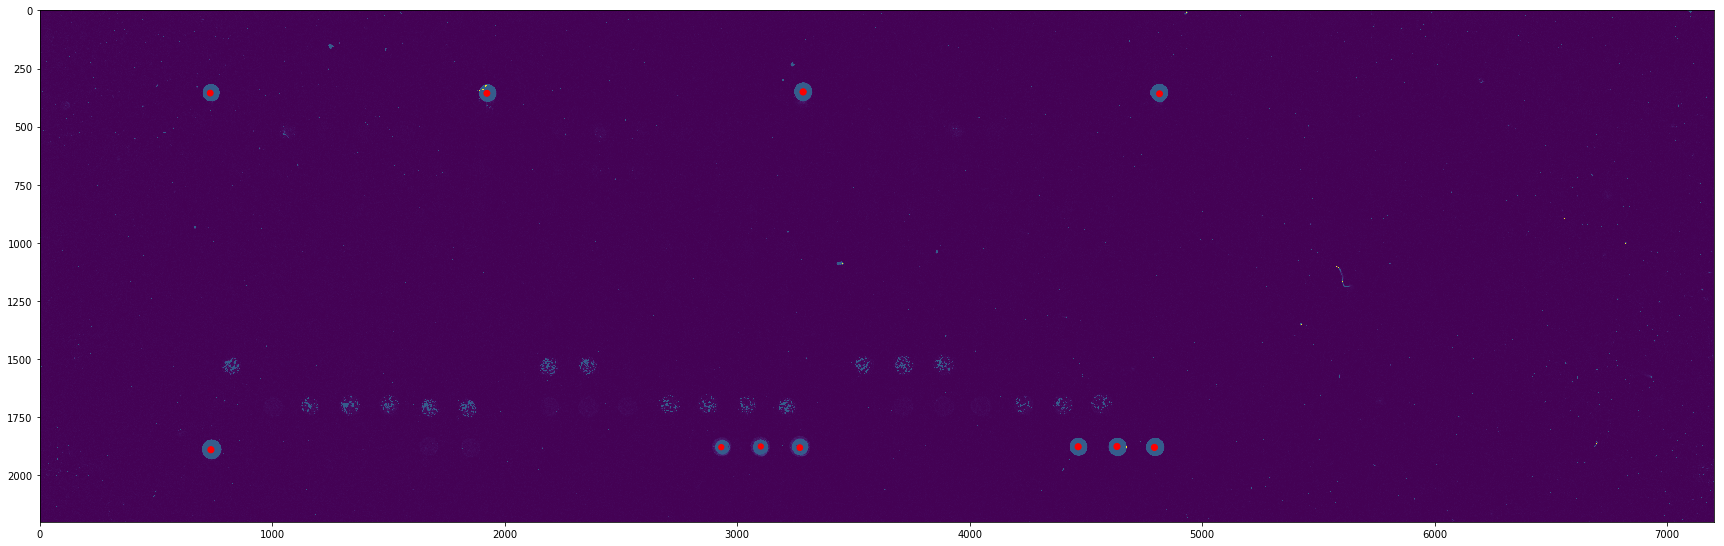

In [26]:
fig, ax = plt.subplots(figsize=(30,10))

implot = plt.imshow(im.T)
#for i_circle in range(circles.shape[1]):
plt.scatter(circles[0,:,1],circles[0,:,0],s=circles[0,:,2],color="r")
plt.show()

In [27]:
Peptides=pd.DataFrame(pep_cor_unstacked.values,columns=["Peptides"])
Peptides["Column"]=leuchtefix.index.get_level_values(0).values
Peptides["Row"]=leuchtefix.index.get_level_values(1).values
Peptides["x"]=0
Peptides["y"]=0

display(Peptides)


,Peptides,Column,Row,x,y
0,Leuchtefix 1.0,1,1,0,0
1,blank,1,2,0,0
2,blank,1,3,0,0
3,blank,1,4,0,0
4,blank,1,5,0,0
5,blank,1,6,0,0
6,blank,1,7,0,0
7,Leuchtefix 1.0,1,8,0,0
8,blank,1,9,0,0
9,blank,1,10,0,0


In [29]:
circles_pandas = pd.DataFrame(circles[0,:,0:2], columns=["x","y"])
display(circles_pandas)


   


,x,y
0,1878.5,2931.5
1,356.5,1923.5
2,1880.5,3269.5
3,350.5,3283.5
4,1889.5,736.5
5,1875.5,4633.5
6,1879.5,4794.5
7,355.5,733.5
8,1875.5,3101.5
9,1876.5,4466.5


In [31]:
nonzero_ids=leuchtefix.nonzero()
print(Peptides.iloc[nonzero_ids])



               
        
    


    


            Peptides  Column  Row  x  y
0     Leuchtefix 1.0       1    1  0  0
7     Leuchtefix 1.0       1    8  0  0
15    Leuchtefix 1.0       1   16  0  0
24    Leuchtefix 1.0       1   25  0  0
225   Leuchtefix 1.0      10    1  0  0
238  Leuchtefix 0.25      10   14  0  0
239  Leuchtefix 0.25      10   15  0  0
240  Leuchtefix 0.25      10   16  0  0
247   Leuchtefix 0.5      10   23  0  0
248   Leuchtefix 0.5      10   24  0  0
249   Leuchtefix 0.5      10   25  0  0


In [32]:
from scipy.optimize import leastsq, minimize
from sklearn.neighbors import NearestNeighbors

def get_spot_grid(shape, pitch, center_x, center_y, rotation=0):
    x_spots, y_spots = np.meshgrid(
             (np.arange(shape[1]) - (shape[1]-1)/2.)*pitch, 
             (np.arange(shape[0]) - (shape[0]-1)/2.)*pitch)
    theta = rotation/180.*np.pi
    x_spots = x_spots*np.cos(theta) - y_spots*np.sin(theta) + center_x
    y_spots = x_spots*np.sin(theta) + y_spots*np.cos(theta) + center_y
    return x_spots, y_spots

def get_fluorspots_ongrid(x_grid,y_grid,xe, ye):
    
    xy_grid=np.vstack([x_grid,y_grid]).reshape(2,-1).T
    xy_circles=np.vstack([xe, ye]).reshape(2,-1).T
    index_nearest=nearest_neighbour(xy_circles,xy_grid)   
    return xy_grid[index_nearest,0],xy_grid[index_nearest,1]
        


def nearest_neighbour(points_a, points_b):
    tree = spatial.cKDTree(points_b)
    return tree.query(points_a)[1]


def get_mean_distance(x1, y1, x2, y2):
    return np.sqrt((x1 - x2)**2 + (y1 - y2)**2).mean()


def err_func(params, xe, ye,gridshape):
    pitch, center_x, center_y, rotation = params
    x_grid, y_grid = get_spot_grid(gridshape, pitch, center_x, center_y, rotation)
    x_spots, y_spots = get_fluorspots_ongrid(x_grid, y_grid, xe, ye)
    return get_mean_distance(x_spots, y_spots, xe, ye)



[  1.69489042e+02   1.11649362e+03   2.76706946e+03   4.80821035e-02]


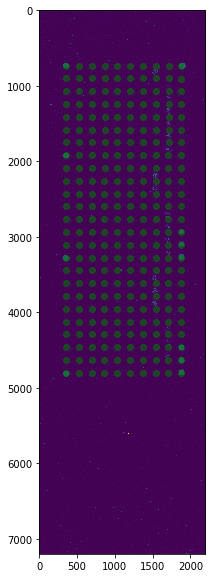

In [34]:


pitch=(circles_pandas["x"].max()-circles_pandas["x"].min())/(Peptides["Column"].iloc[nonzero_ids].max()-Peptides["Column"].iloc[nonzero_ids].min())
center_x=circles_pandas["x"].min()+0.5*(circles_pandas["x"].max()-circles_pandas["x"].min())
center_y=circles_pandas["y"].min()+0.5*(circles_pandas["y"].max()-circles_pandas["y"].min())
gridshape=(Peptides["Row"].max(),Peptides["Column"].max())






best=minimize(err_func, x0=(pitch, center_x, center_y, 0), args=(circles_pandas["x"].values,circles_pandas["y"].values,gridshape))
print(best.x)
X,Y=get_spot_grid(gridshape,pitch=best.x[0],center_x=best.x[1],center_y=best.x[2],rotation=best.x[3])



fig, ax = plt.subplots(figsize=(30,10))
plt.scatter(X,Y,alpha=0.5, color="g")
implot = plt.imshow(im)

plt.show()
